In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='1kbp_raw'

In [3]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [171]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['subclass']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

In [54]:
marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

In [172]:
marker_list = marker_list.sample(frac=1)

In [164]:
marker_list

group  cell_type  rank       gene  recurrence     auroc  \
10190  Glutamatergic    L5/6 NP     2  LOC729732           9  0.996556   
18205   Non-neuronal       Endo     4      MECOM           6  0.976422   
14086   Non-neuronal       Endo     7      THSD4           6  0.960882   
5065   Glutamatergic      L5 ET     4      KCNN2           8  0.975618   
2427   Glutamatergic    L5/6 NP    11      PRR16           9  0.970075   
...              ...        ...   ...        ...         ...       ...   
20143   Non-neuronal       VLMC    10    SLC6A12           5  0.750924   
9747   Glutamatergic      L6 CT     2      TRPM3           9  0.980615   
4029       GABAergic      Lamp5    11       BMP6           9  0.796766   
19356   Non-neuronal  Micro-PVM    12        SYK           7  0.943017   
18375   Non-neuronal      Oligo    10     RNF220           8  0.977424   

       fold_change  fold_change_detection  expression  precision  ...  \
10190     9.882573               1.061927  309.046020   0.038708  ...   
18205    90.406748               6.963227  420.972285   0.255780  ...   
14086    68.013064              11.293538  320.886327   0.288512  ...   
5065      6.078831               1.176834  160.620419   0.005303  ...   
2427      5.435327               1.183653  177.748824   0.043336  ...   
...            ...                    ...         ...        ...  ...   
20143    14.633564               4.904252    0.000000   0.220270  ...   
9747      6.736993               1.285151  314.708461   0.045309  ...   
4029      6.056926               4.226331   28.202162   0.319920  ...   
19356   103.059873              57.953810  168.894268   0.707071  ...   
18375    17.990036               2.650449  549.604643   0.605362  ...   

       H200.1025_SSv4  H200.1023_SSv4  H18.30.002_10Xv3  H200.1023_10Xv3  \
10190            True            True              True             True   
18205           False           False              True            False   
14086           False           False              True            False   
5065            False            True              True             True   
2427             True            True              True             True   
...               ...             ...               ...              ...   
20143           False           False              True              NaN   
9747             True            True              True             True   
4029             True            True              True             True   
19356            True            True              True            False   
18375            True            True              True            False   

      H18.30.001_10Xv3  H19.30.001_10Xv3  H19.30.001_NextGEM H19.30.002_10Xv3  \
10190             True              True                True             True   
18205             True              True                True             True   
14086             True              True                True             True   
5065              True              True                True             True   
2427              True              True                True             True   
...                ...               ...                 ...              ...   
20143             True              True                True             True   
9747              True              True                True             True   
4029              True              True                True             True   
19356            False              True                True             True   
18375             True              True                True             True   

       Ensembl_gene_identifier     Symbol  
10190          ENSG00000283674  LOC729732  
18205          ENSG00000085276      MECOM  
14086          ENSG00000187720      THSD4  
5065           ENSG00000080709      KCNN2  
2427           ENSG00000184838      PRR16  
...                        ...        ...  
20143          ENSG00000111181    SLC6A12  
9747       

In [173]:
df_gene_tp = pd.DataFrame(my_data ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())




In [174]:
df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

df_gene_tp = df_gene_tp.fillna(0)

In [9]:
import seaborn as sns
%matplotlib inline

In [167]:
marker_list

group  cell_type  rank       gene  recurrence     auroc  \
10190  Glutamatergic    L5/6 NP     2  LOC729732           9  0.996556   
18205   Non-neuronal       Endo     4      MECOM           6  0.976422   
14086   Non-neuronal       Endo     7      THSD4           6  0.960882   
5065   Glutamatergic      L5 ET     4      KCNN2           8  0.975618   
2427   Glutamatergic    L5/6 NP    11      PRR16           9  0.970075   
...              ...        ...   ...        ...         ...       ...   
20143   Non-neuronal       VLMC    10    SLC6A12           5  0.750924   
9747   Glutamatergic      L6 CT     2      TRPM3           9  0.980615   
4029       GABAergic      Lamp5    11       BMP6           9  0.796766   
19356   Non-neuronal  Micro-PVM    12        SYK           7  0.943017   
18375   Non-neuronal      Oligo    10     RNF220           8  0.977424   

       fold_change  fold_change_detection  expression  precision  ...  \
10190     9.882573               1.061927  309.046020   0.038708  ...   
18205    90.406748               6.963227  420.972285   0.255780  ...   
14086    68.013064              11.293538  320.886327   0.288512  ...   
5065      6.078831               1.176834  160.620419   0.005303  ...   
2427      5.435327               1.183653  177.748824   0.043336  ...   
...            ...                    ...         ...        ...  ...   
20143    14.633564               4.904252    0.000000   0.220270  ...   
9747      6.736993               1.285151  314.708461   0.045309  ...   
4029      6.056926               4.226331   28.202162   0.319920  ...   
19356   103.059873              57.953810  168.894268   0.707071  ...   
18375    17.990036               2.650449  549.604643   0.605362  ...   

       H200.1025_SSv4  H200.1023_SSv4  H18.30.002_10Xv3  H200.1023_10Xv3  \
10190            True            True              True             True   
18205           False           False              True            False   
14086           False           False              True            False   
5065            False            True              True             True   
2427             True            True              True             True   
...               ...             ...               ...              ...   
20143           False           False              True              NaN   
9747             True            True              True             True   
4029             True            True              True             True   
19356            True            True              True            False   
18375            True            True              True            False   

      H18.30.001_10Xv3  H19.30.001_10Xv3  H19.30.001_NextGEM H19.30.002_10Xv3  \
10190             True              True                True             True   
18205             True              True                True             True   
14086             True              True                True             True   
5065              True              True                True             True   
2427              True              True                True             True   
...                ...               ...                 ...              ...   
20143             True              True                True             True   
9747              True              True                True             True   
4029              True              True                True             True   
19356            False              True                True             True   
18375             True              True                True             True   

       Ensembl_gene_identifier     Symbol  
10190          ENSG00000283674  LOC729732  
18205          ENSG00000085276      MECOM  
14086          ENSG00000187720      THSD4  
5065           ENSG00000080709      KCNN2  
2427           ENSG00000184838      PRR16  
...                        ...        ...  
20143          ENSG00000111181    SLC6A12  
9747       

In [168]:
lut = dict(zip( marker_list.cell_type.drop_duplicates(), sns.color_palette("Set2", marker_list.cell_type.drop_duplicates().shape[0]).as_hex()[:]))


row_colors = marker_list.cell_type.map(lut)


In [175]:
lut = dict(zip( marker_list.group.drop_duplicates(), sns.color_palette("Set2", marker_list.group.drop_duplicates().shape[0]).as_hex()[:]))


row_colors = marker_list.group.map(lut)

In [156]:
lut = dict(zip( marker_list.cell_type.drop_duplicates(), "rbg"))


row_colors = marker_list.cell_type.map(lut)

In [46]:
lut = dict(zip(marker_list.classt.unique(), "rbg"))
row_colors = marker_list.classt.map(lut)

In [176]:
row_colors = pd.DataFrame({'cc':marker_list.cell_type.map(lut)})

In [177]:
import random
bin_random = random.sample(range(2875011), 1000)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


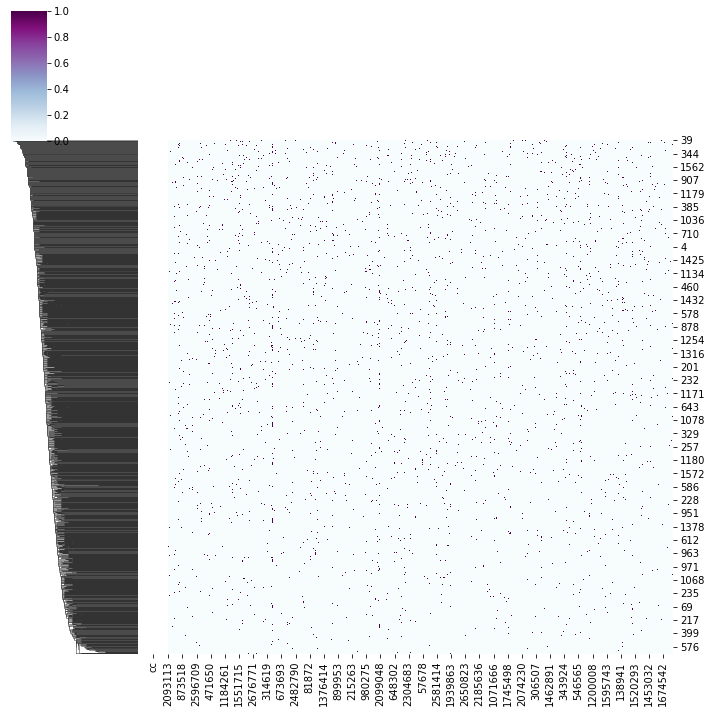

In [178]:
sns.clustermap(df_gene_tp.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", row_colors=row_colors.reset_index(drop=True), col_cluster=False, robust=False)



In [ ]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, :]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()

In [158]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [159]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [162]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()

In [134]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [135]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)


In [140]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.cell_type, labels={'color': 'cell_type'}
)


fig_2d.show()

In [43]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [53]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

In [121]:
sns.color_palette("Paired", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928',
 '#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [124]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()



In [129]:
marker_list.group.head()

0    L6 CT
1    L6 CT
2    L6 CT
3    L6 CT
4    L6 CT
Name: group, dtype: object

In [127]:
fig_2d = px.scatter(
     x=df_proj_2d[0], y=df_proj_2d[1],
    color=df_proj_2d.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

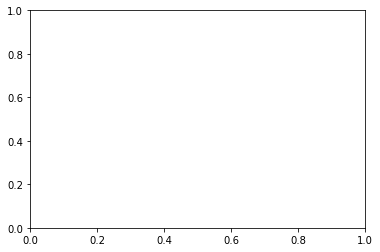

In [58]:
sns.scatterplot(proj_2d[:,0],proj_2d[:,1] , color=marker_list.group)

In [59]:
df_proj_2d= pd.DataFrame(proj_2d)

In [61]:
df_proj_2d['group'] = marker_list.group

In [62]:
df_proj_2d['cell_type'] = marker_list.cell_type

In [63]:
df_proj_2d['classt'] = marker_list.classt

In [72]:
df_proj_2d = df_proj_2d.sort_values(by=['classt', 'group', 'cell_type'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



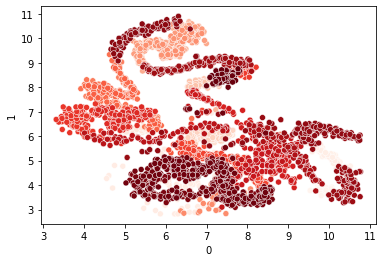

In [79]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette="Reds")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



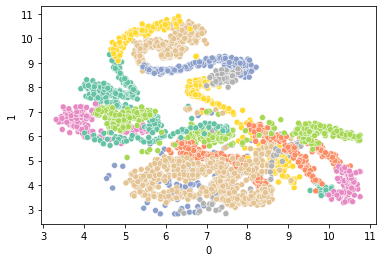

In [109]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.group, legend=False, palette=sns.color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0]))


In [111]:
color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0])

NameError: name 'color_palette' is not defined

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



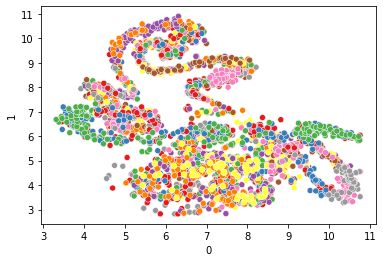

In [107]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette=sns.color_palette("Set1", df_proj_2d.cell_type.drop_duplicates().shape[0]))


In [98]:
df_proj_2d.group.drop_duplicates().shape[0]

24

In [83]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [84]:
sns.color_palette("Paired", 20)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0)]

In [118]:
sns.color_palette("Set2",20).as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']

In [113]:
y = sns.color_palette("Set2",20)

In [116]:
y.as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']